# Titanic survival prediction notebook
A notebook to create predictions for the Titanic Kaggle challange: https://www.kaggle.com/c/titanic/overview

## Content
This notebook contains:
1. Basic data visualization
2. basic data cleaning
3. model training and selection

## Next steps
1. More feature engineering of for example the "Cabin-variable and the "Name"-variable to see if those variables contain extra information
2. Investigate the missclassified passangers to see if they contain any pattern (with a data set this small it's easy to go through all of the missclassified passangers in the training set)

In [1]:
#==================================================
# Import libraries & set seed
#==================================================
import os

import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import time

# machine learning
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Other sklearn funcitonality
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve

np.random.seed(342)

## Set metrics
A section where we set some metrics for the training methodology below:
* SCORING_METRIC: Which metric shall the models be fitted to optimize
* N_JOBS: How many CPU cores are going to be used fitting the models?

In [2]:
SCORING_METRIC = 'accuracy'  # This is the 
N_JOBS = -1

## Load and investigate data

In [3]:
#==============================================================================
# Load Training and test data
#==============================================================================
# Load training dataset
base_path = os.path.dirname(os.getcwd())
file_path = os.path.join(base_path, "data")
file_name = "train.csv"

data_destination_train = os.path.join(file_path, file_name) # Full file path + name
raw_data_train=pd.read_csv(data_destination_train,keep_default_na=False,na_values='')

# Load test dataset - we will perform the same transformations we are making to the training dataset in parallel
# in order be able to run the model on it at the end
file_name = "test.csv"
data_destination_test = os.path.join(file_path, file_name) # Full file path + name
raw_data_test=pd.read_csv(data_destination_test,keep_default_na=False,na_values='')

# Check if it worked
raw_data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
raw_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
# Investigate data

# We see that Age have missing values 
print(raw_data_train.shape)
raw_data_train.describe(include="all")


(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Allen, Mr. William Henry",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [6]:
cont_variables = [ "Age", "Fare"]
categorical_variables = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]
dependent_variable = "Survived"

## Plotting data
* Basic visualisaiton of the independent and dependent data

In [7]:
# Scatter plot
#plt.scatter(raw_data_train["Age"],raw_data_train["Survived"])

def plot_dependent_variable_split_continous(data_set_in, dependent_variable, independent_variable):
    # create figure
    fig = plt.figure(figsize=(16,6))
    ax=fig.add_subplot(121)
    ax.scatter(raw_data_train[independent_variable], raw_data_train[dependent_variable])
    
    ax=fig.add_subplot(122)
    # Survived
    sns.distplot(raw_data_train.loc[raw_data_train[dependent_variable] == 1][independent_variable], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, label = "Survived")

    # Not Survived
    sns.distplot(raw_data_train.loc[raw_data_train[dependent_variable] == 0][independent_variable], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3}, label = "Died")
    
    # Set the title
    plt.title('Density Plot with dependent variable split with independent variable ' + independent_variable)
    
    # show the plot
    plt.show()
    

In [8]:
def plot_dependent_variable_split_categorical(data_set_in, dependent_variable, independent_variable):
    # create figure
    fig = plt.figure(figsize=(16,6))
    
    ax=fig.add_subplot(122)
    
    ture_dependent = data_set_in.loc[data_set_in[dependent_variable] == 1]
    false_dependent = data_set_in.loc[data_set_in[dependent_variable] == 0]
    
    true_relative_frequency = ture_dependent[independent_variable].astype("category").value_counts(sort = False) / len(ture_dependent)
    false_relative_frequency = false_dependent[independent_variable].astype("category").value_counts(sort = False) / len(false_dependent)
    
    x = np.asarray(list(range(1, len(true_relative_frequency)*1 + 1, 1)))
    
    try:
        ax.bar(x-0.1, true_relative_frequency, width = 0.2, color = "g")
        ax.bar(x+0.1, false_relative_frequency, width = 0.2, color = "r")

        x_labels = ture_dependent[independent_variable].value_counts(sort = False).index

        #ture_dependent[independent_variable].value_counts().plot(kind = "bar", color = "green")
        #false_dependent[independent_variable].value_counts().plot(kind = "bar", color = "blue")

        plt.xticks(x, x_labels)

        # Set the title
        plt.title('Relative frequency Plot with dependent variable split with independent variable ' + independent_variable)

    
        # add the frequency plot
        ax=fig.add_subplot(121)
        ax.bar(x-0.1, ture_dependent[independent_variable].astype("category").value_counts(sort = False), width = 0.2, color = "g")
        ax.bar(x+0.1, false_dependent[independent_variable].astype("category").value_counts(sort = False), width = 0.2, color = "r")
        plt.xticks(x, x_labels)
        plt.title('frequency Plot with dependent variable split with independent variable ' + independent_variable)

    except:
        print("Error plotting variable: " + indep_variable)
    
    plt.show()

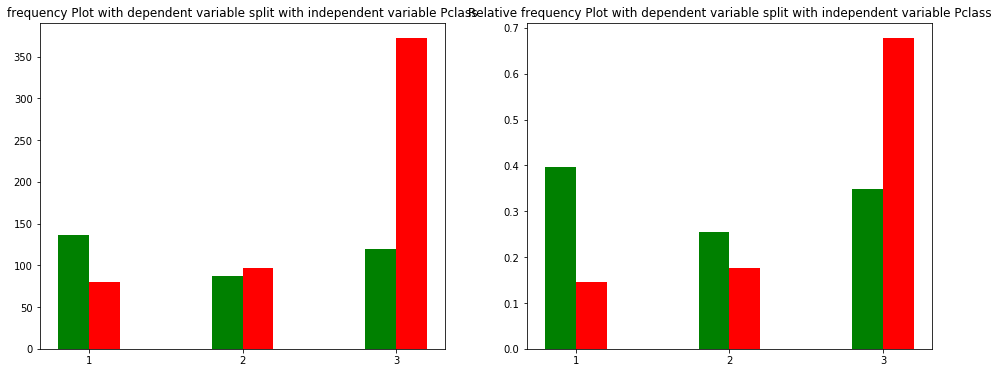

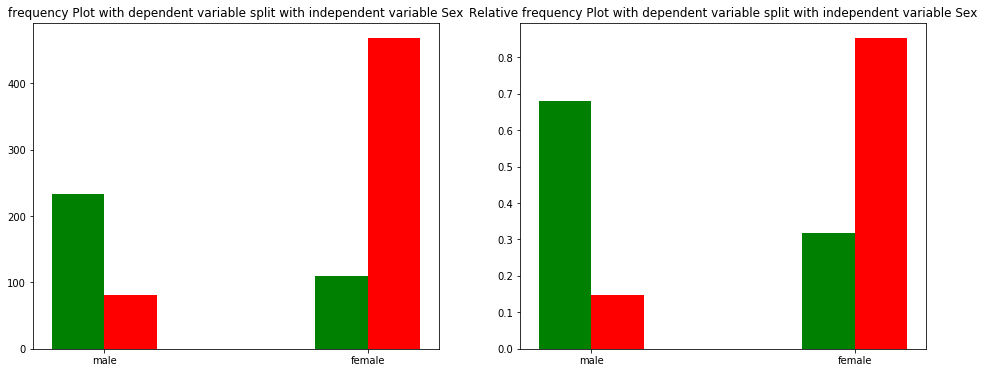

Error plotting variable: SibSp


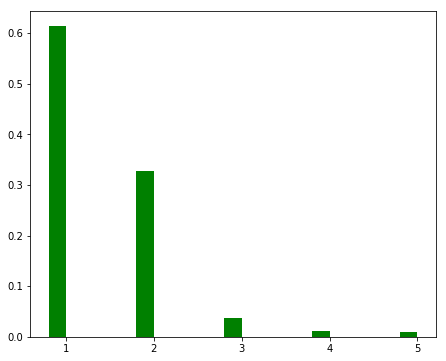

Error plotting variable: Parch


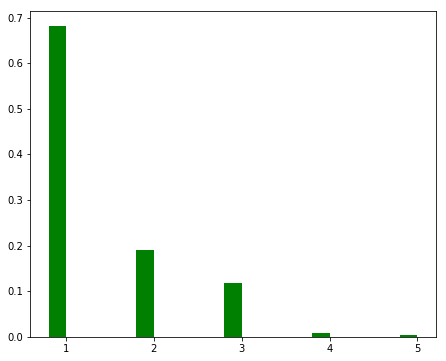

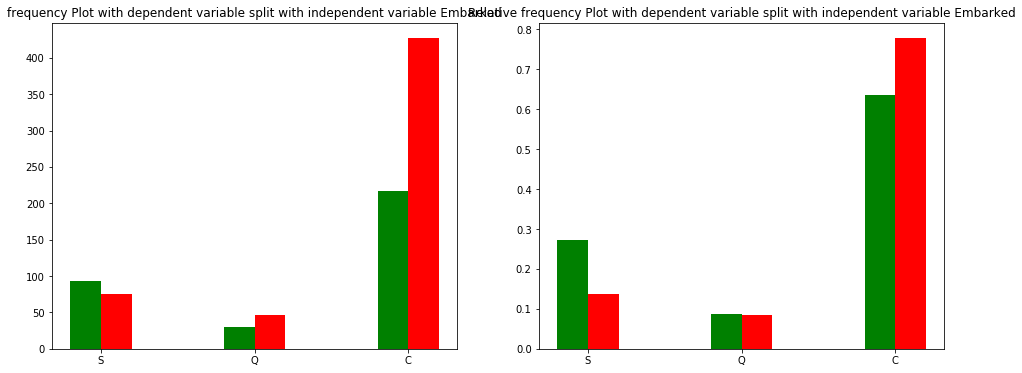

In [9]:
for indep_variable in categorical_variables:
    plot_dependent_variable_split_categorical(raw_data_train, dependent_variable, indep_variable)
    plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


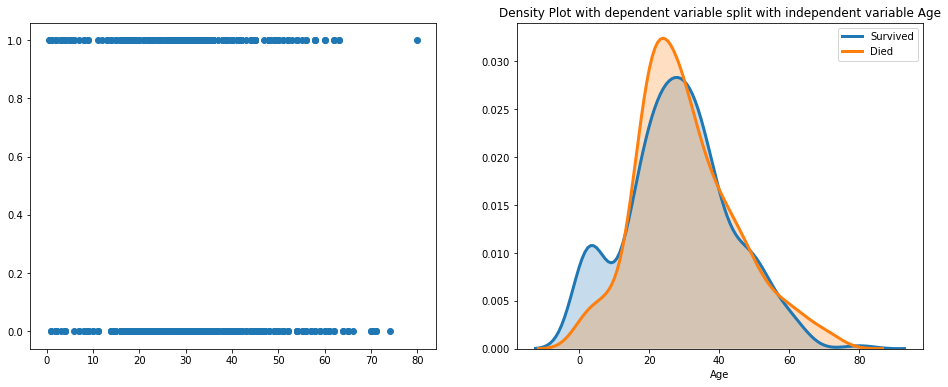

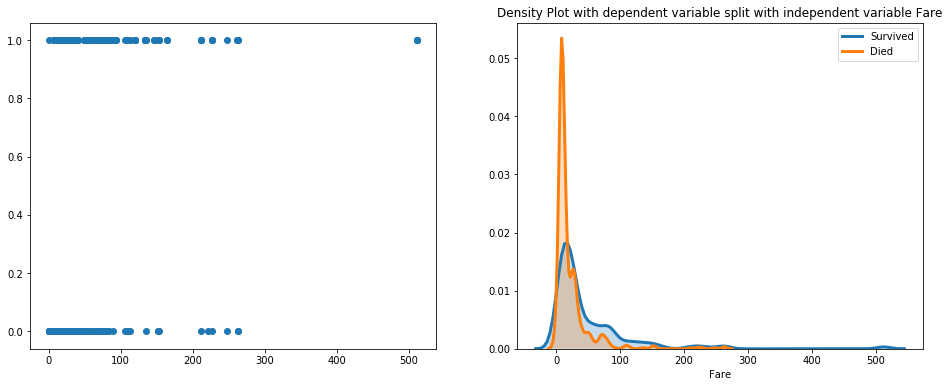

In [10]:
# We wee that the variables age and Fare have some outliner values and a non-linear relationship and should be bucketed

bin_array_age = [0.0, 5, 10, 15, 20, 50, 60, 1000]
bin_array_fare = [0.0, 10, 20, 40, 100, 10000]

for indep_variable in cont_variables:
    plot_dependent_variable_split_continous(raw_data_train, dependent_variable, indep_variable)
    plt.show()

## Clean data by dropping/replacing missing data
* Create functions for cleaning the data that takes a df as input to be able to clean both test and train data set

In [11]:
def create_family_dummy_variable(df_in_train, df_in_test):
    # funciton that creates a variable for the number of family members
    
    return df_in_train, df_in_test

In [12]:
# Fix missing values in continous categories
def fix_missing_age(df_in_train, df_in_test):
    # Funciton that fixes mising values for age
    mean_age = df_in_train.append(df_in_test)["Age"].mean()
    df_in_train.loc[df_in_train["Age"].isnull(), "Age"] = mean_age
    df_in_test.loc[df_in_test["Age"].isnull(), "Age"] = mean_age
    
    return df_in_train, df_in_test
    

In [13]:
# Fix missing values in continous categories
def fix_missing_fare(df_in_train, df_in_test):
    # Funciton that fixes mising values for age
    mean_age = df_in_train.append(df_in_test)["Fare"].mean()
    df_in_train.loc[df_in_train["Fare"].isnull(), "Fare"] = mean_age
    df_in_test.loc[df_in_test["Fare"].isnull(), "Fare"] = mean_age
    
    return df_in_train, df_in_test

In [14]:
def fix_missing_embarkement(df_in_train, df_in_test):
    # Funciton that fixes mising values for age
    most_frequent_embarkement = df_in_train.append(df_in_test)["Embarked"].value_counts().index[0]
    df_in_train.loc[df_in_train["Embarked"].isnull(), "Embarked"] = most_frequent_embarkement
    df_in_test.loc[df_in_test["Embarked"].isnull(), "Embarked"] = most_frequent_embarkement
    
    return df_in_train, df_in_test

In [15]:
# Function that drops the unnecicary variables
def drop_variables(df_in_train, df_in_test):
    # Funciton that drops variables
    variables_to_drop = ["PassengerId", "Ticket", "Cabin", "Name"]
    df_in_train = df_in_train.drop(variables_to_drop, axis = 1)
    df_in_test = df_in_test.drop(variables_to_drop, axis = 1)

    return df_in_train, df_in_test

In [16]:
# Function that bins continous variable
def bin_continous_variable(df_in_train, df_in_test, variable_to_bin, bin_array):
    
    df_in_train = df_in_train.copy()
    df_in_test = df_in_test.copy()
    
    train_bins= pd.cut(df_in_train[variable_to_bin], bins = bin_array)
    test_bins = pd.cut(df_in_test[variable_to_bin], bins = bin_array)
    
    # add the binned variable to the dataframe
    df_in_train[variable_to_bin+"_bins"] = train_bins
    df_in_test[variable_to_bin+"_bins"] = test_bins
    
    # drop the original variable
    df_in_train = df_in_train.drop(variable_to_bin, axis = 1)
    df_in_test = df_in_test.drop(variable_to_bin, axis = 1)
    
    return df_in_train, df_in_test

In [17]:
# We limit Sib and Parch to 0, 1, 2+
def limit_categorical_variable(df_in_train, df_in_test, categorical_variable, limit = 2):
    df_in_train.loc[df_in_train[categorical_variable] >= limit, categorical_variable] = limit
    df_in_test.loc[df_in_test[categorical_variable] >= limit, categorical_variable] = limit
    return df_in_train, df_in_test
    

In [18]:
# Function that returns dummy variables
def get_dummies(df_in_train, df_in_test, categorical_variables):
    
    for variable in categorical_variables:
        df_in_train[variable] = df_in_train[variable].astype('category')
        df_in_test[variable] = df_in_test[variable].astype('category')
    
    df_dummies_train=df_in_train[categorical_variables]
    df_dummies_test=df_in_test[categorical_variables]
    
    #create dummies
    df_dummies_train = pd.get_dummies(df_dummies_train, drop_first=True)
    df_dummies_test = pd.get_dummies(df_dummies_test, drop_first=True)
    
    # add the dummies to the datasets
    df_in_train = df_in_train.merge(right = df_dummies_train, left_index=True, right_index=True, how='inner')
    df_in_test = df_in_test.merge(right = df_dummies_test, left_index=True, right_index=True, how='inner')
    
    # drop the categorical variables
    df_in_train = df_in_train.drop(categorical_variables, axis = 1)
    df_in_test = df_in_test.drop(categorical_variables, axis = 1)
    
    return df_in_train, df_in_test

In [19]:
# applying all of the cleaning and transformation functions on the train and test data sets
cleaned_train, cleaned_test = fix_missing_age(raw_data_train, raw_data_test)
cleaned_train, cleaned_test = fix_missing_fare(cleaned_train, cleaned_test)
cleaned_train, cleaned_test = fix_missing_embarkement(cleaned_train, cleaned_test)
cleaned_train, cleaned_test = drop_variables(cleaned_train, cleaned_test)

# limit the categorical variables
cleaned_train, cleaned_test = limit_categorical_variable(cleaned_train, cleaned_test, "SibSp")
cleaned_train, cleaned_test = limit_categorical_variable(cleaned_train, cleaned_test, "Parch")

cleaned_train, cleaned_test = get_dummies(cleaned_train, cleaned_test, categorical_variables)

# we now bin the continous variables
cleaned_train_binned, cleaned_test_binned = bin_continous_variable(cleaned_train, cleaned_test, "Age", bin_array_age)
cleaned_train_binned, cleaned_test_binned = bin_continous_variable(cleaned_train_binned, cleaned_test_binned, "Fare", bin_array_fare)
cleaned_train_binned, cleaned_test_binned = get_dummies(cleaned_train_binned, cleaned_test_binned, ["Age_bins", "Fare_bins"])

cleaned_train.head()
cleaned_train.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Survived,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,Parch_1,Parch_2,Embarked_Q,Embarked_S
0,0,22.0,7.2500,0,1,1,1,0,0,0,0,1
1,1,38.0,71.2833,0,0,0,1,0,0,0,0,0
2,1,26.0,7.9250,0,1,0,0,0,0,0,0,1
3,1,35.0,53.1000,0,0,0,1,0,0,0,0,1
4,0,35.0,8.0500,0,1,1,0,0,0,0,0,1


## Plot the data again

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


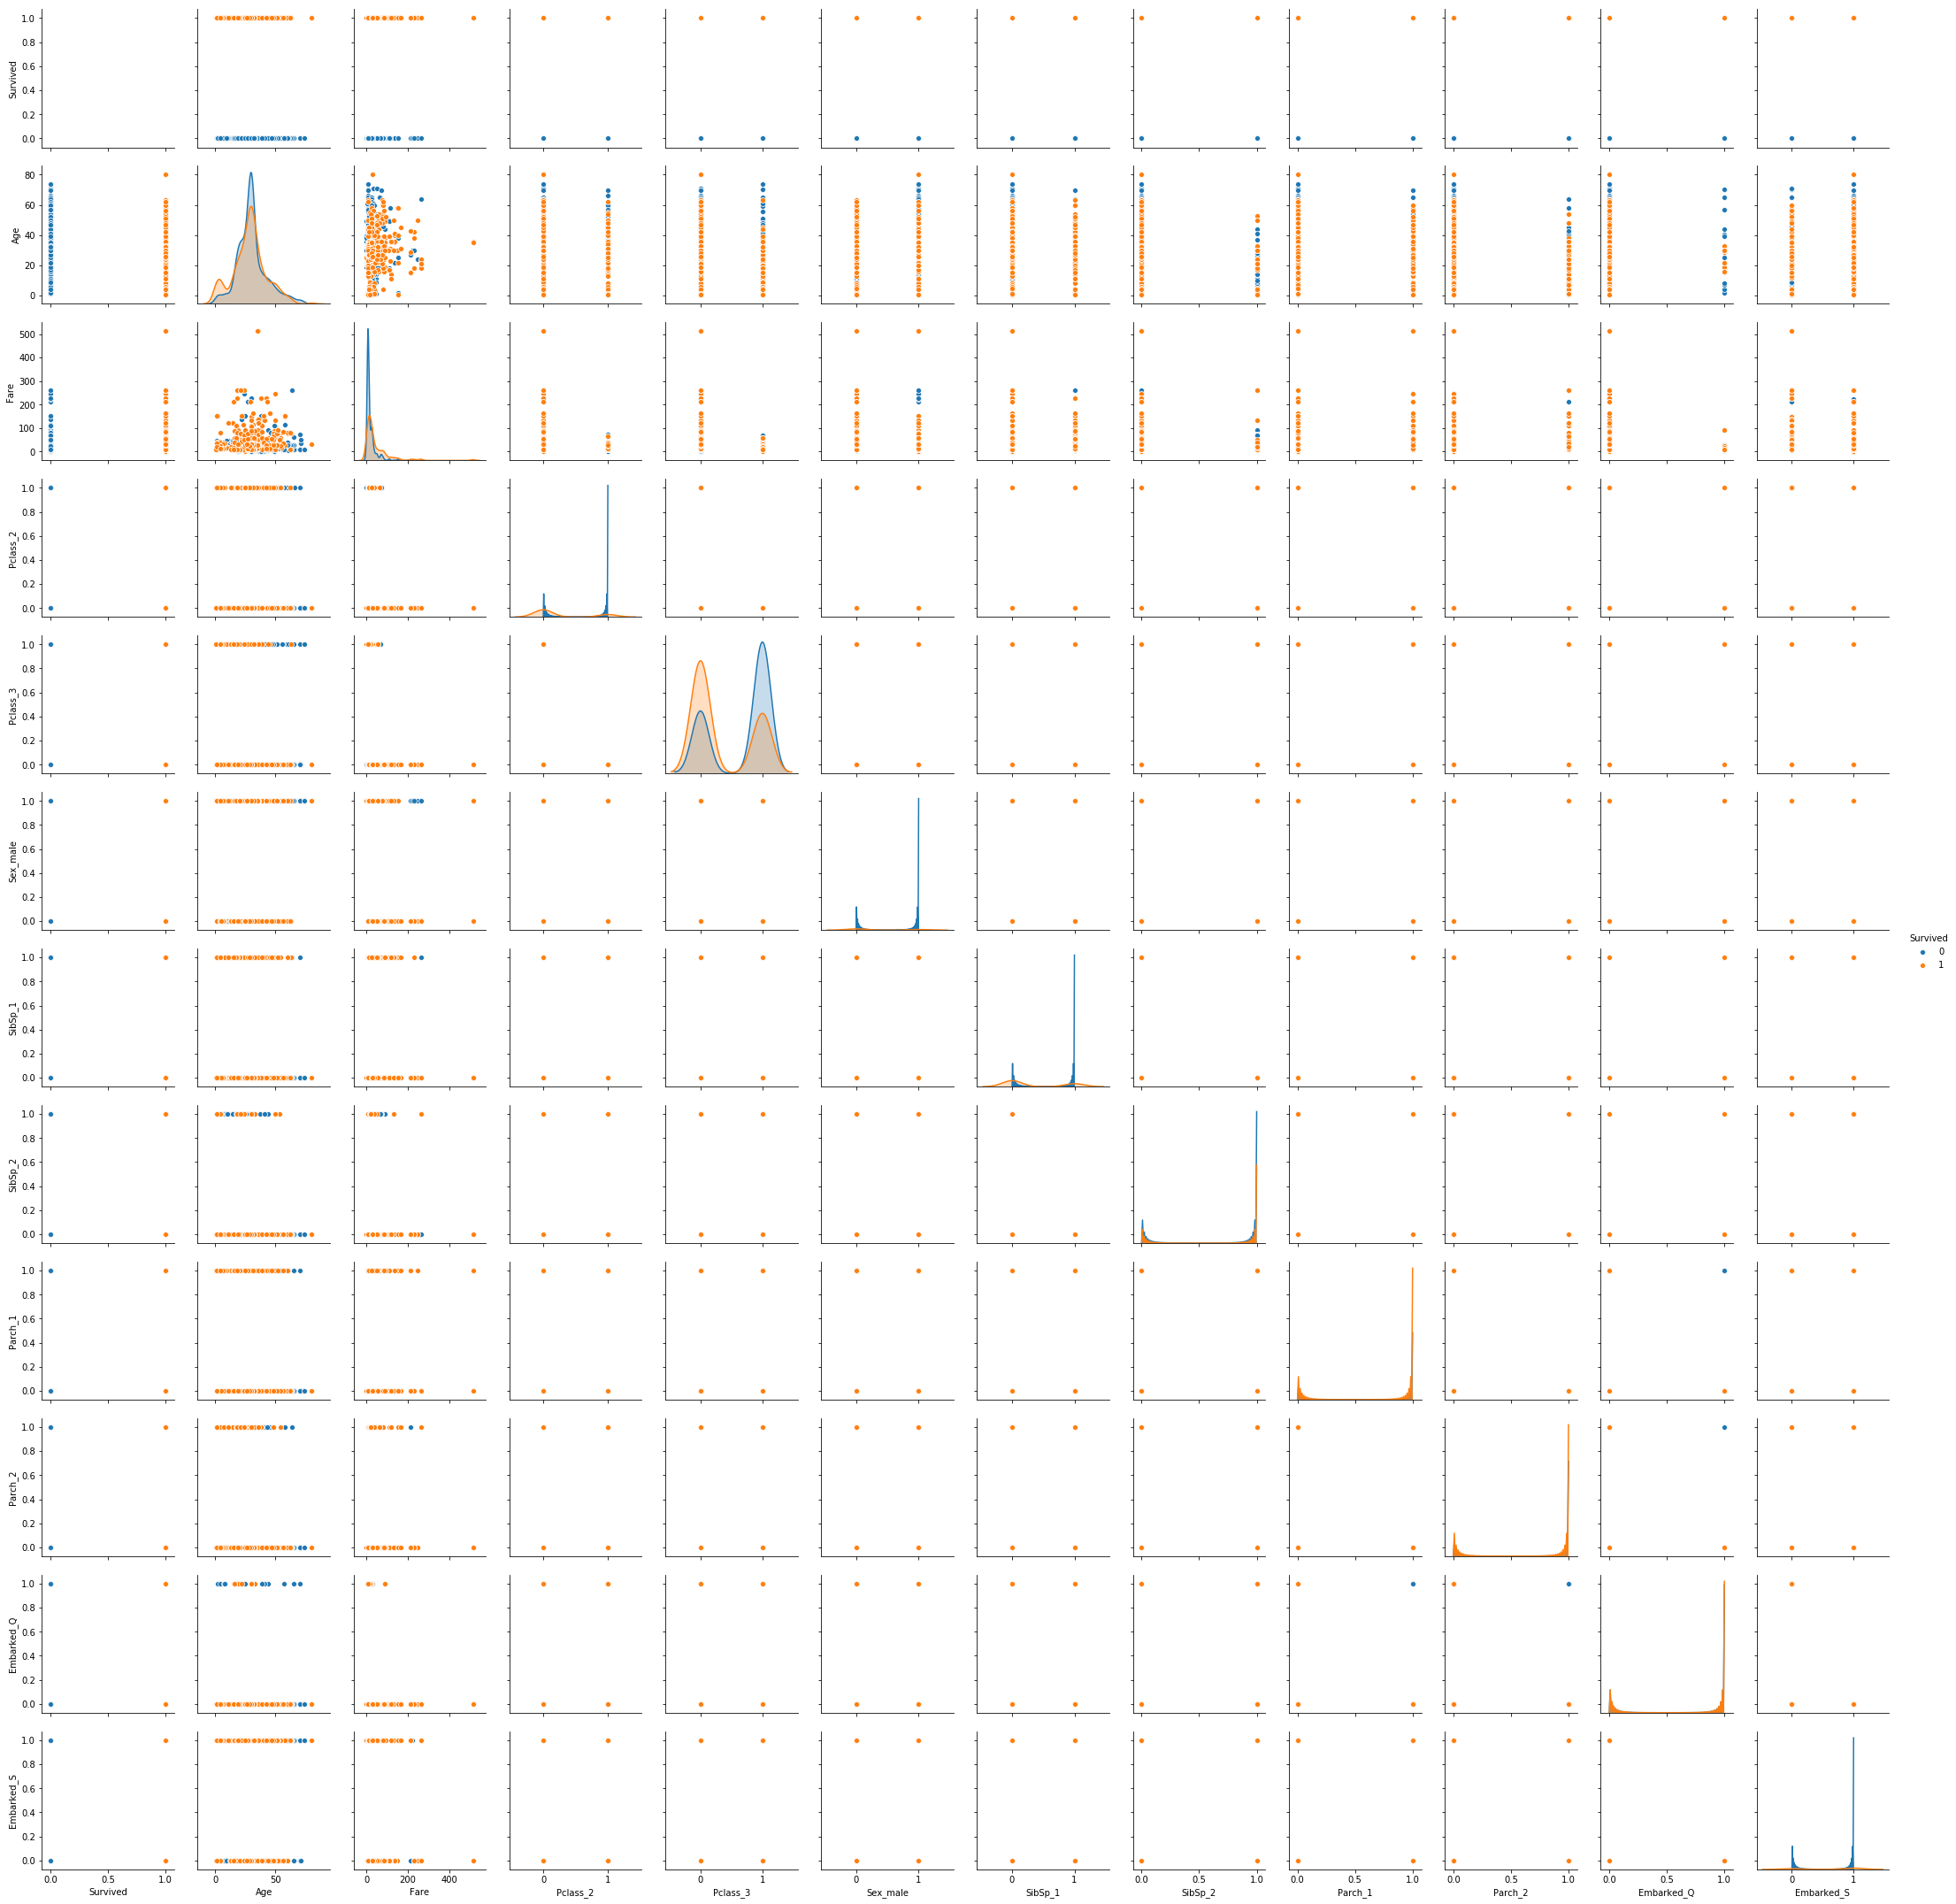

In [20]:
sns.pairplot(cleaned_train, hue = 'Survived')

## Prepare data for model training
* Do a train/test split

In [21]:
#==============================================================================
# Data sampling
#==============================================================================

#Create X and y
#X=cleaned_train_binned.drop([dependent_variable],axis=1)
#y=cleaned_train_binned[dependent_variable].astype('int')
X=cleaned_train.drop([dependent_variable],axis=1)
y=cleaned_train[dependent_variable].astype('int')

# Evaluate the model by splitting the training data into train and validation sets, setting seed=93
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.25, random_state=93)

print("Percentage of survivors in training dataset: %0.6s"%(y_train.mean()))
print("Percentage of survivors in validation dataset: %0.6s"%(y_validation.mean()))

Percentage of survivors in training dataset: 0.3847
Percentage of survivors in validation dataset: 0.3811


In [22]:
# create the x for submitting the test
x_test = cleaned_test

## Train models
* Create functionality 

In [23]:
# Funcitons to plot the trained results
def calculate_AUC(model, test_actuals, test_features, ax = None):
    # Calculate the AUC
    logit_roc_auc = roc_auc_score(test_actuals, model.predict_proba(test_features)[:,1])
    fpr, tpr, thresholds = roc_curve(test_actuals, model.predict_proba(test_features)[:,1])

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

    
    ax.plot(fpr, tpr, label='Model (AUC = %0.2f)' % logit_roc_auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), ax = None):
    """Generate a simple plot of the test and training learning curve"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    

    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
        
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    ax.legend(loc="best")

def plot_model_fit_summary(model, test_actuals, test_features, title):
    
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    
    # Create the subplots
    calculate_AUC(model, test_actuals, test_features, ax=axs[0])
    
    # Create the subplots
    plot_learning_curve(model, title, test_features, test_actuals, ax=axs[1])
    
    
    fig.suptitle('Test_title')
    
    plt.show()
    

In [24]:
test_model = KNeighborsClassifier()
test_model.fit(X_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


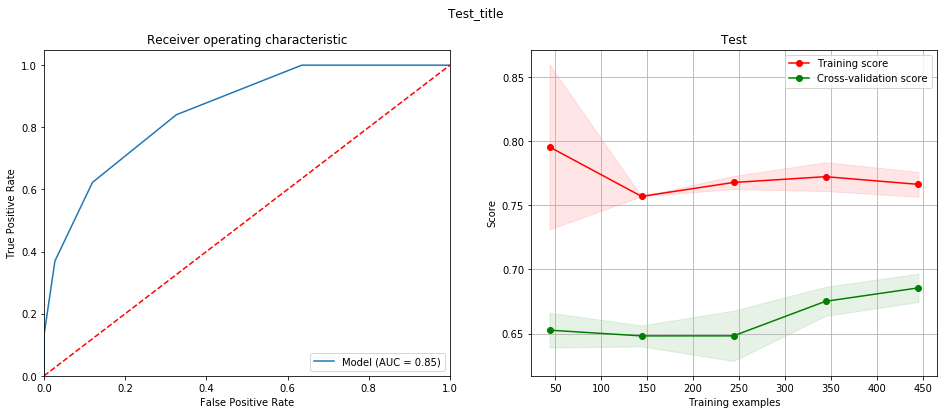

In [25]:
plot_model_fit_summary(test_model, y_train, X_train, "Test")

## Model pipe testing
* Do a wide testing of multiple models using SKLearn pipeline functionality

Start training RandomForest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Stop training RandomForest. Time taken 0.3480668067932129 s
Start training LogisticRegression


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Stop training LogisticRegression. Time taken 0.3280179500579834 s
Start training SVC
Stop training SVC. Time taken 1.149144172668457 s
Start training KNN
Stop training KNN. Time taken 0.28527140617370605 s
Start training GaussianNB
Stop training GaussianNB. Time taken 0.03381991386413574 s
Start training GradientBoost
Stop training GradientBoost. Time taken 1.0150649547576904 s


,GaussianNB,KNN,LogisticRegression,RandomForest,SVC,GradientBoost
0,0.80398,0.805694,0.842029,0.907315,0.925777,0.946898


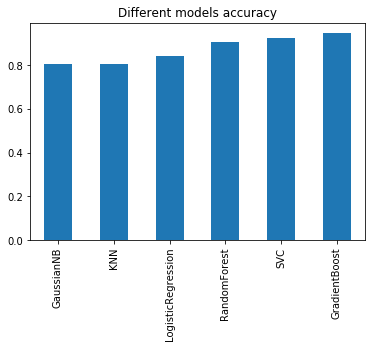

In [26]:
# Test multiple funcitons with GridSearchCV

models_to_train = [RandomForestClassifier(), 
                   LogisticRegression(penalty='l2'),
                   SVC(probability=True),
                   KNeighborsClassifier(),
                   GaussianNB(),
                   GradientBoostingClassifier()
                  ]

model_names = ['RandomForest', 'LogisticRegression', 'SVC', 'KNN', "GaussianNB", "GradientBoost"]

best_models = []
best_model_AUC = []

parameters = {
    'RandomForest':{
        'max_depth':np.arange(5,7),
        'max_features':np.arange(7,9)
             },
    'LogisticRegression':{
        'C':[10e-2, 10e-1, 1, 10, 10e2]
        },
    'SVC':{
        'kernel': ['rbf'],
        'gamma': [0.1, 1, 10],
        'C': [0.1, 1, 10]
    },
    'KNN':{
        'n_neighbors': [1, 3, 5, 10 , 20]
    },
    'GaussianNB': {},
    'GradientBoost':{
        'min_samples_leaf':[1, 3, 5],
        'max_depth': [1, 3, 5]
    }
    }

# Find out the best model
for i in range(0,len(model_names)):
    
    
    act_model = models_to_train[i]
    act_model_name = model_names[i]
    print("Start training " + act_model_name)
    
    # Get the start time
    start_time = time.time()
    
    act_params = parameters[act_model_name]
    
    act_model = GridSearchCV(act_model, act_params, cv=5, scoring=SCORING_METRIC, n_jobs = N_JOBS)
    act_model.fit(X_train, y_train)

    act_best_model = act_model.best_estimator_
    best_models.append(act_best_model)
    best_model_AUC.append(roc_auc_score(y_train, act_best_model.predict_proba(X_train)[:,1])) #predict_proba [:,1]
    
    # get the end time
    time_taken = time.time() - start_time
    print("Stop training " + act_model_name + ". Time taken {} s".format(time_taken))

# displaying the results
result_df = pd.DataFrame(best_model_AUC).T
result_df.columns = model_names
result_df = result_df[result_df.iloc[-1].sort_values(ascending=True).index]

result_df.T.plot(kind='bar', title = "Different models " + SCORING_METRIC, legend = False )
result_df.head()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


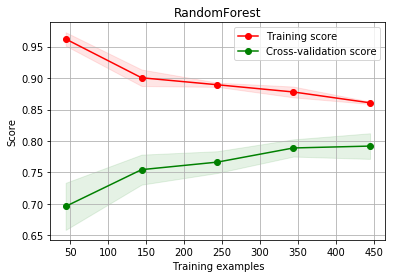

In [27]:
plot_learning_curve(best_models[0], "RandomForest", X_train, y_train)

## Investigate the best models form above
* Based on pipeline model testing we choose the best models for more investigation

### Logistic regression
* Currently no need to dig deeper in the Logistic regression 

### Random forest

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 5, 'max_features': 5, 'n_estimators': 500}


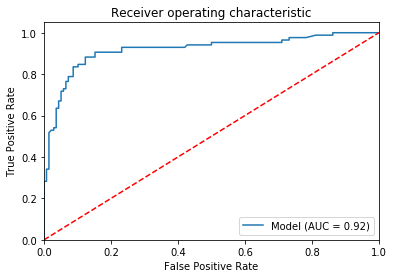

In [28]:
#==============================================================================
# Random Forest
#==============================================================================

# Create the model object
random_forest_v1 = RandomForestClassifier()

parameters = {
    'max_depth':[1, 3, 5, 7, 9, 11],
    'max_features':[1, 5, 9],
    'n_estimators':[1, 10, 100, 500]
    }

random_forest_v1 = GridSearchCV(random_forest_v1, parameters, cv=10, scoring=SCORING_METRIC, n_jobs=N_JOBS)

random_forest_v1.fit(X_train, y_train)

print(random_forest_v1.best_params_)

# Call calculate_AUC
calculate_AUC(random_forest_v1.best_estimator_, y_validation, X_validation)

{'max_depth': 4, 'max_features': 4, 'n_estimators': 125}


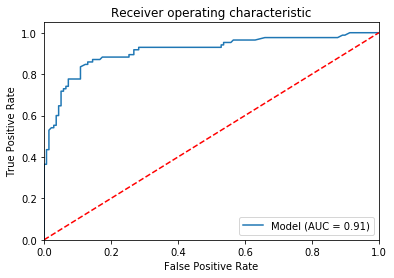

In [29]:
# Zoom in on the relevant parambeters and refit the model with a smaller mesh

# Create the model object
random_forest_v2 = RandomForestClassifier()

parameters = {
    'max_depth':[4, 5, 6],
    'max_features':[4,5,6],
    'n_estimators':[75, 100, 125]
    }

random_forest_v2 = GridSearchCV(random_forest_v2, parameters, cv=10, scoring=SCORING_METRIC, n_jobs=N_JOBS)

random_forest_v2.fit(X_train, y_train)

print(random_forest_v2.best_params_)

# Call calculate_AUC
calculate_AUC(random_forest_v2.best_estimator_, y_validation, X_validation)


### GradientBoost

{'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 100}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


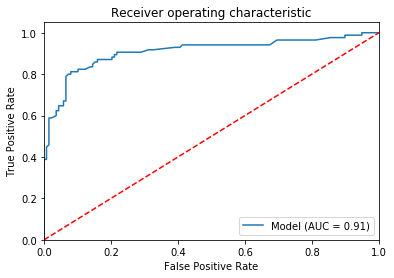

In [30]:
# Create the model object
gb_v1 = GradientBoostingClassifier()

parameters = {
        'min_samples_leaf':[1, 3, 5],
        'max_depth': [2, 3, 4],
        'n_estimators': [10, 100, 1000]
    }

gb_model_v1 = GridSearchCV(gb_v1, parameters, cv=10, scoring=SCORING_METRIC, n_jobs=N_JOBS)

gb_model_v1.fit(X_train, y_train)

print(gb_model_v1.best_params_)

# Call calculate_AUC
calculate_AUC(gb_model_v1.best_estimator_, y_validation, X_validation)

{'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 100}


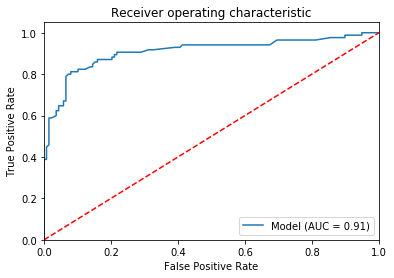

In [31]:
# Drill down in the fitting
gb_v2 = GradientBoostingClassifier()

parameters = {
        'min_samples_leaf':[1, 2],
        'max_depth': [1, 2, 3],
        'n_estimators': [50, 100, 200]
    }

gb_model_v2 = GridSearchCV(gb_v2, parameters, cv=10, scoring=SCORING_METRIC, n_jobs=N_JOBS)

gb_model_v2.fit(X_train, y_train)

print(gb_model_v2.best_params_)

# Call calculate_AUC
calculate_AUC(gb_model_v2.best_estimator_, y_validation, X_validation)

### Invistegate wrong answers
* Next steps would be to investigate the missclassified data further
* This section should be developed further

In [32]:
model_to_test = gb_model_v2
y_comp = model_to_test.predict(X_validation)

comparison = X_validation.merge(right=pd.DataFrame(y_validation), left_index=True, right_index = True)
print(comparison.shape)
comparison = comparison.merge(right= pd.DataFrame(y_comp, index = comparison.index,
                                                  columns = ["predicted_survive"]), left_index=True, right_index = True)
comparison["right_prediction"] = 0
comparison.loc[comparison["Survived"] == comparison["predicted_survive"], "right_prediction"] = 1
comparison.head()

(223, 12)


,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,Parch_1,Parch_2,Embarked_Q,Embarked_S,Survived,predicted_survive,right_prediction
261,3.000000,31.3875,0,1,1,0,1,0,1,0,1,1,0,0
856,45.000000,164.8667,0,0,0,1,0,1,0,0,1,1,1,1
538,29.881138,14.5000,0,1,1,0,0,0,0,0,1,0,0,1
158,29.881138,8.6625,0,1,1,0,0,0,0,0,1,0,0,1
451,29.881138,19.9667,0,1,1,1,0,0,0,0,1,0,0,1


In [33]:
miss_classified = comparison.loc[comparison["right_prediction"] == 0]
print(miss_classified.shape)
miss_classified.head()

(36, 14)


,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,Parch_1,Parch_2,Embarked_Q,Embarked_S,Survived,predicted_survive,right_prediction
261,3.000000,31.3875,0,1,1,0,1,0,1,0,1,1,0,0
701,35.000000,26.2875,0,0,1,0,0,0,0,0,1,1,0,0
681,27.000000,76.7292,0,0,1,0,0,0,0,0,0,1,0,0
502,29.881138,7.6292,0,1,0,0,0,0,0,1,0,0,1,0
612,29.881138,15.5000,0,1,0,1,0,0,0,1,0,1,0,0


In [34]:
raw_data_train_wrong_prediciton = raw_data_train.loc[miss_classified.index]
raw_data_train_wrong_prediciton.shape

(36, 12)

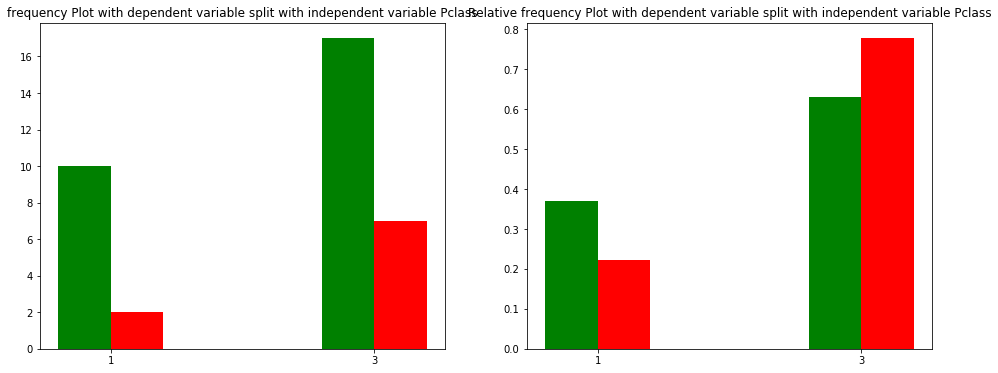

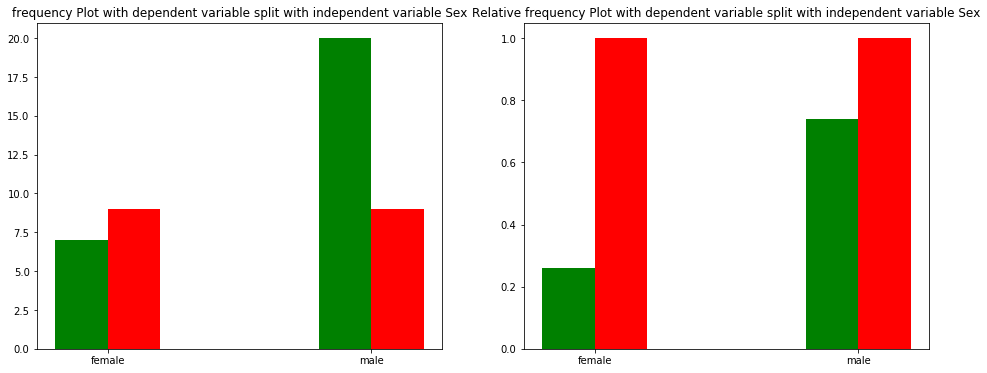

Error plotting variable: SibSp


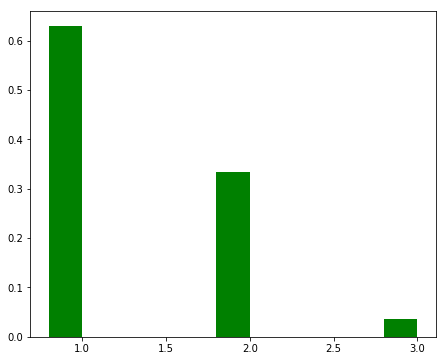

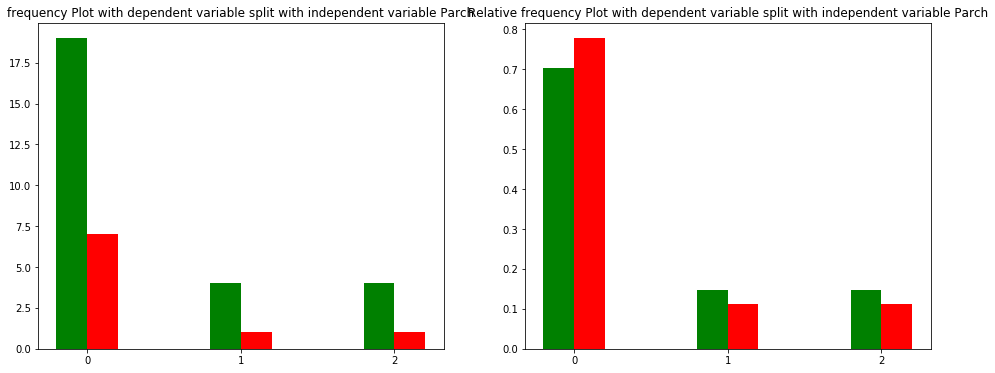

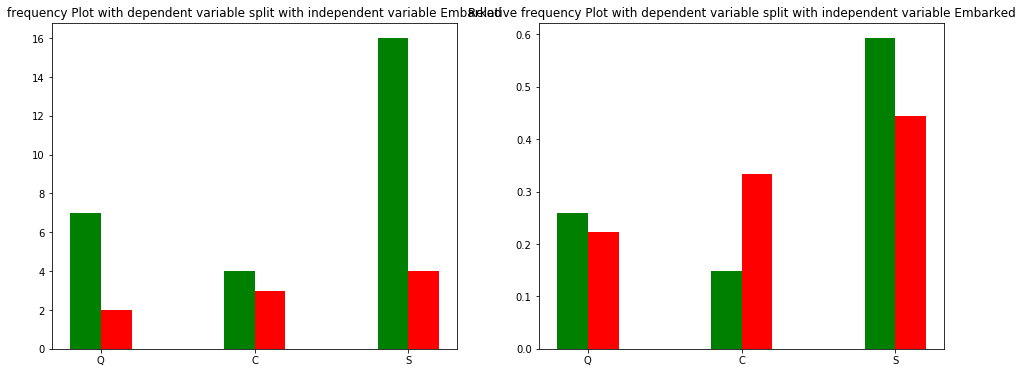

In [35]:
for indep_variable in categorical_variables:
    plot_dependent_variable_split_categorical(raw_data_train_wrong_prediciton, dependent_variable, indep_variable)
    plt.show()

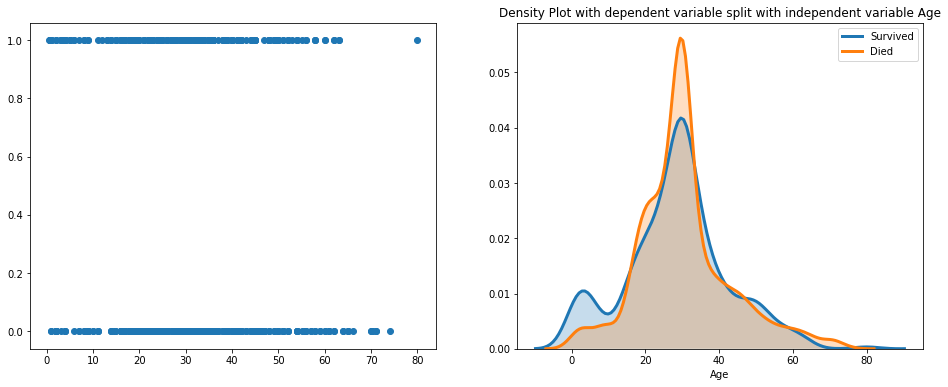

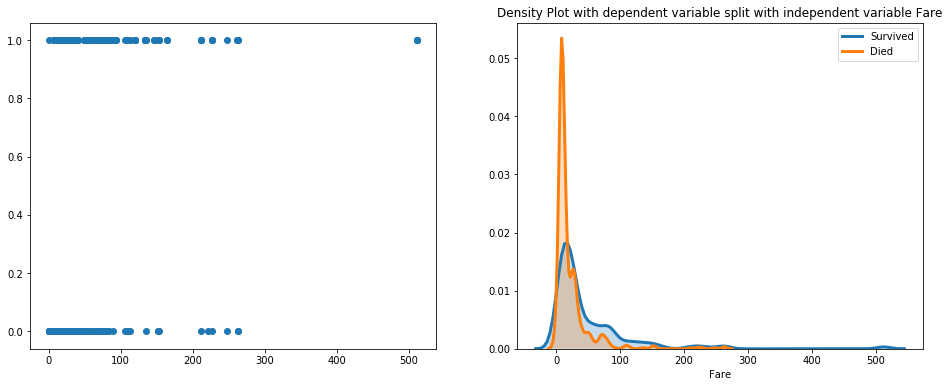

In [36]:
for indep_variable in cont_variables:
    plot_dependent_variable_split_continous(raw_data_train_wrong_prediciton, dependent_variable, indep_variable)
    plt.show()

## Fit the final model with all of the available data
* Final model is choosen based on analysis of of the results from above

In [37]:
final_model = GradientBoostingClassifier(max_depth=2, min_samples_leaf=1, n_estimators=100)
X_final = pd.concat([X_train,X_validation])
y_final = pd.concat([y_train,y_validation])

final_model.fit(X_final, y_final)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

## Create submission file
* Create a submission file to submitt to Kaggle

In [38]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
Age           418 non-null float64
Fare          418 non-null float64
Pclass_2      418 non-null uint8
Pclass_3      418 non-null uint8
Sex_male      418 non-null uint8
SibSp_1       418 non-null uint8
SibSp_2       418 non-null uint8
Parch_1       418 non-null uint8
Parch_2       418 non-null uint8
Embarked_Q    418 non-null uint8
Embarked_S    418 non-null uint8
dtypes: float64(2), uint8(9)
memory usage: 10.3 KB


In [39]:
# create the submit data file
# Select the name of the file and the model that are going to be used

base_path = os.path.dirname(os.getcwd())
file_path = os.path.join(base_path, "output_data")

if not os.path.exists(file_path):
    os.makedirs(file_path)

file_name = "gb_submission_v5.csv"

# Create the output data
y_submit_rf = final_model.predict(x_test)

submit_df = pd.DataFrame(y_submit_rf, columns = ["Survived"])
submit_df.index = raw_data_test["PassengerId"]

submit_df.rename(index=str, columns={"PassengerId": "PassengerId", "0": "Survived"})
submit_df

submit_df.to_csv(os.path.join(file_path,file_name), sep = ",")